In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_squared_error

/Users/Leo.Leung/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# load chocolate_chocolate_chocolate_data
# since the timestamp starts at 0, we should more one timestamp more for every day

prices_d0 = pd.read_csv('data/prices_round_3_day_0.csv', delimiter=';')
prices_d1 = pd.read_csv('data/prices_round_3_day_1.csv', delimiter=';')
prices_d1["timestamp"] += prices_d0["timestamp"].iloc[-1] + 100
prices_d2 = pd.read_csv('data/prices_round_3_day_2.csv', delimiter=';')
prices_d2["timestamp"] += prices_d1["timestamp"].iloc[-1] + 100

prices = pd.concat([prices_d0, prices_d1, prices_d2])


In [6]:
prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2,2999800,GIFT_BASKET,69537,2,69536.0,18.0,69535.0,24.0,69547,2,69548.0,18.0,69550.0,24.0,69542.0,0.0
39996,2,2999900,CHOCOLATE,7749,143,NaN,NaN,NaN,NaN,7751,143,NaN,NaN,NaN,NaN,7750.0,0.0
39997,2,2999900,GIFT_BASKET,69551,1,69550.0,19.0,69549.0,20.0,69561,1,69562.0,19.0,69564.0,20.0,69556.0,0.0
39998,2,2999900,STRAWBERRIES,3984,240,NaN,NaN,NaN,NaN,3985,92,3986.0,148.0,NaN,NaN,3984.5,0.0


In [80]:
prices["mid_price"] = (prices["ask_price_1"] + prices["bid_price_1"])/2


In [81]:
trades_d0 = pd.read_csv('data/trades_round_3_day_0_nn.csv', delimiter=';')
trades_d1 = pd.read_csv('data/trades_round_3_day_1_nn.csv', delimiter=';')
trades_d1["timestamp"] += trades_d0["timestamp"].iloc[-1] + 100
trades_d2 = pd.read_csv('data/trades_round_3_day_2_nn.csv', delimiter=';')
trades_d2["timestamp"] += trades_d1["timestamp"].iloc[-1] + 100

trades = pd.concat([trades_d0, trades_d1, trades_d2])

# del trades_d0, trades_d1, trades_d2

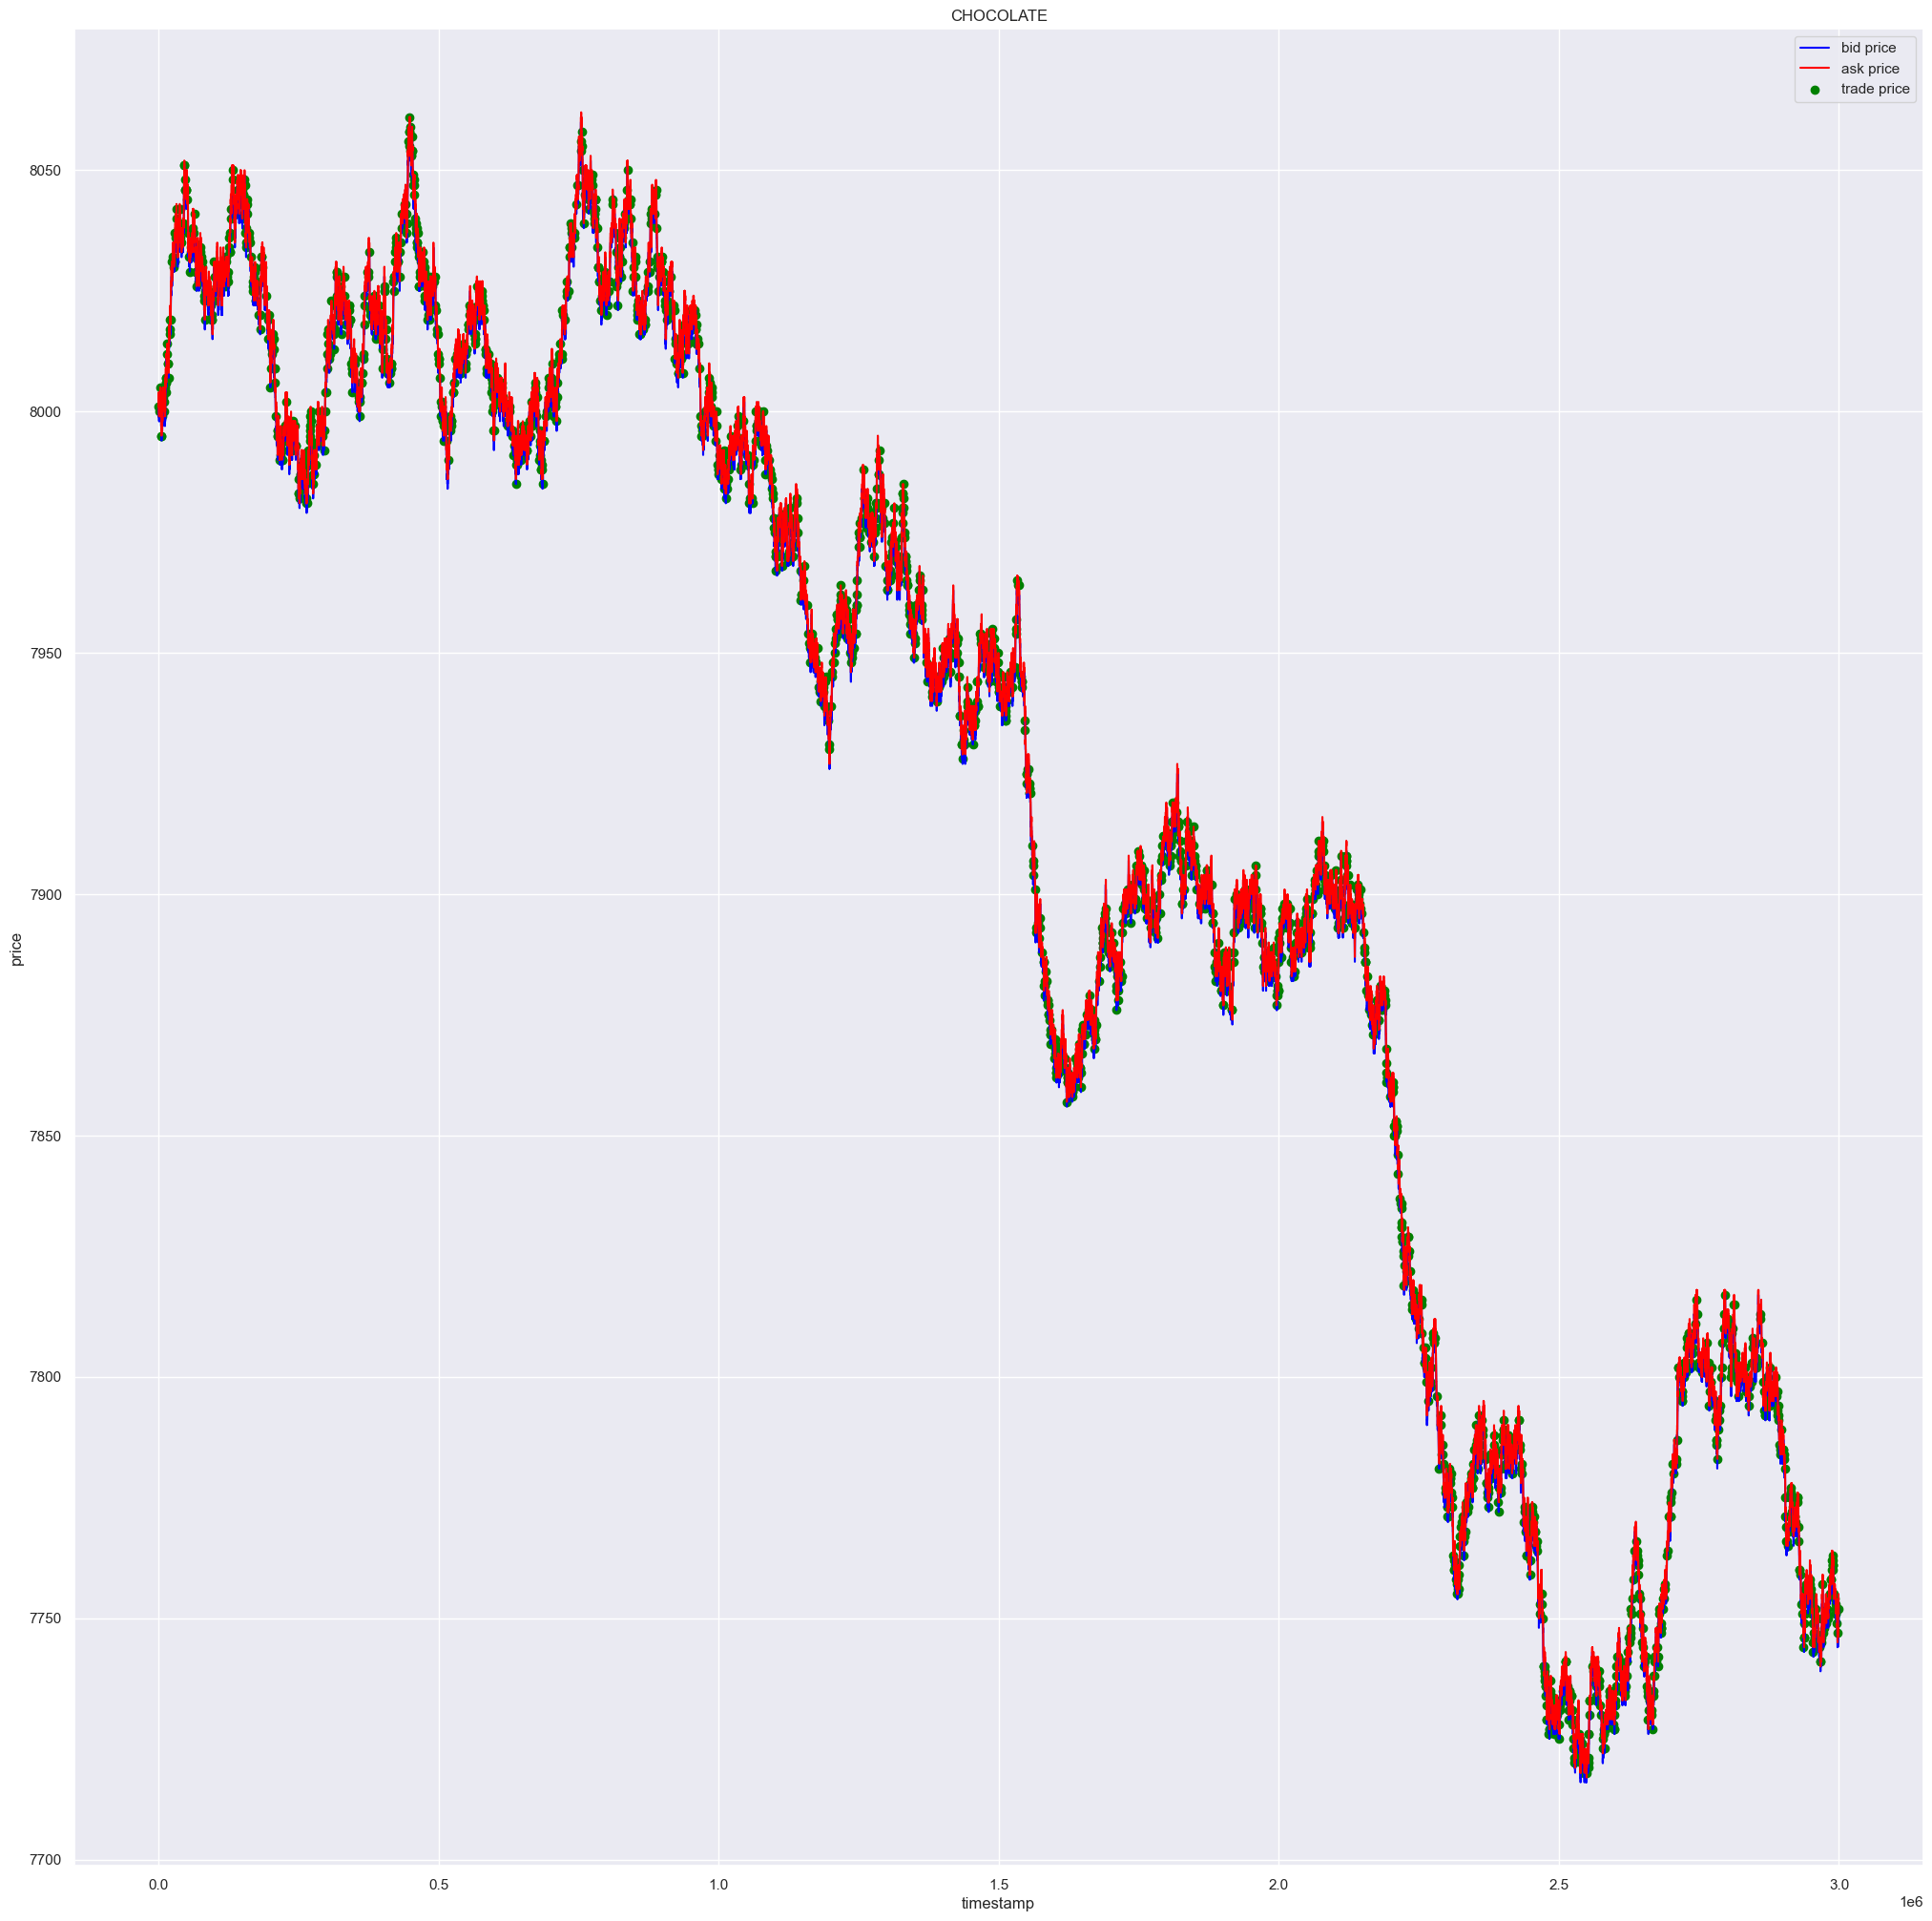

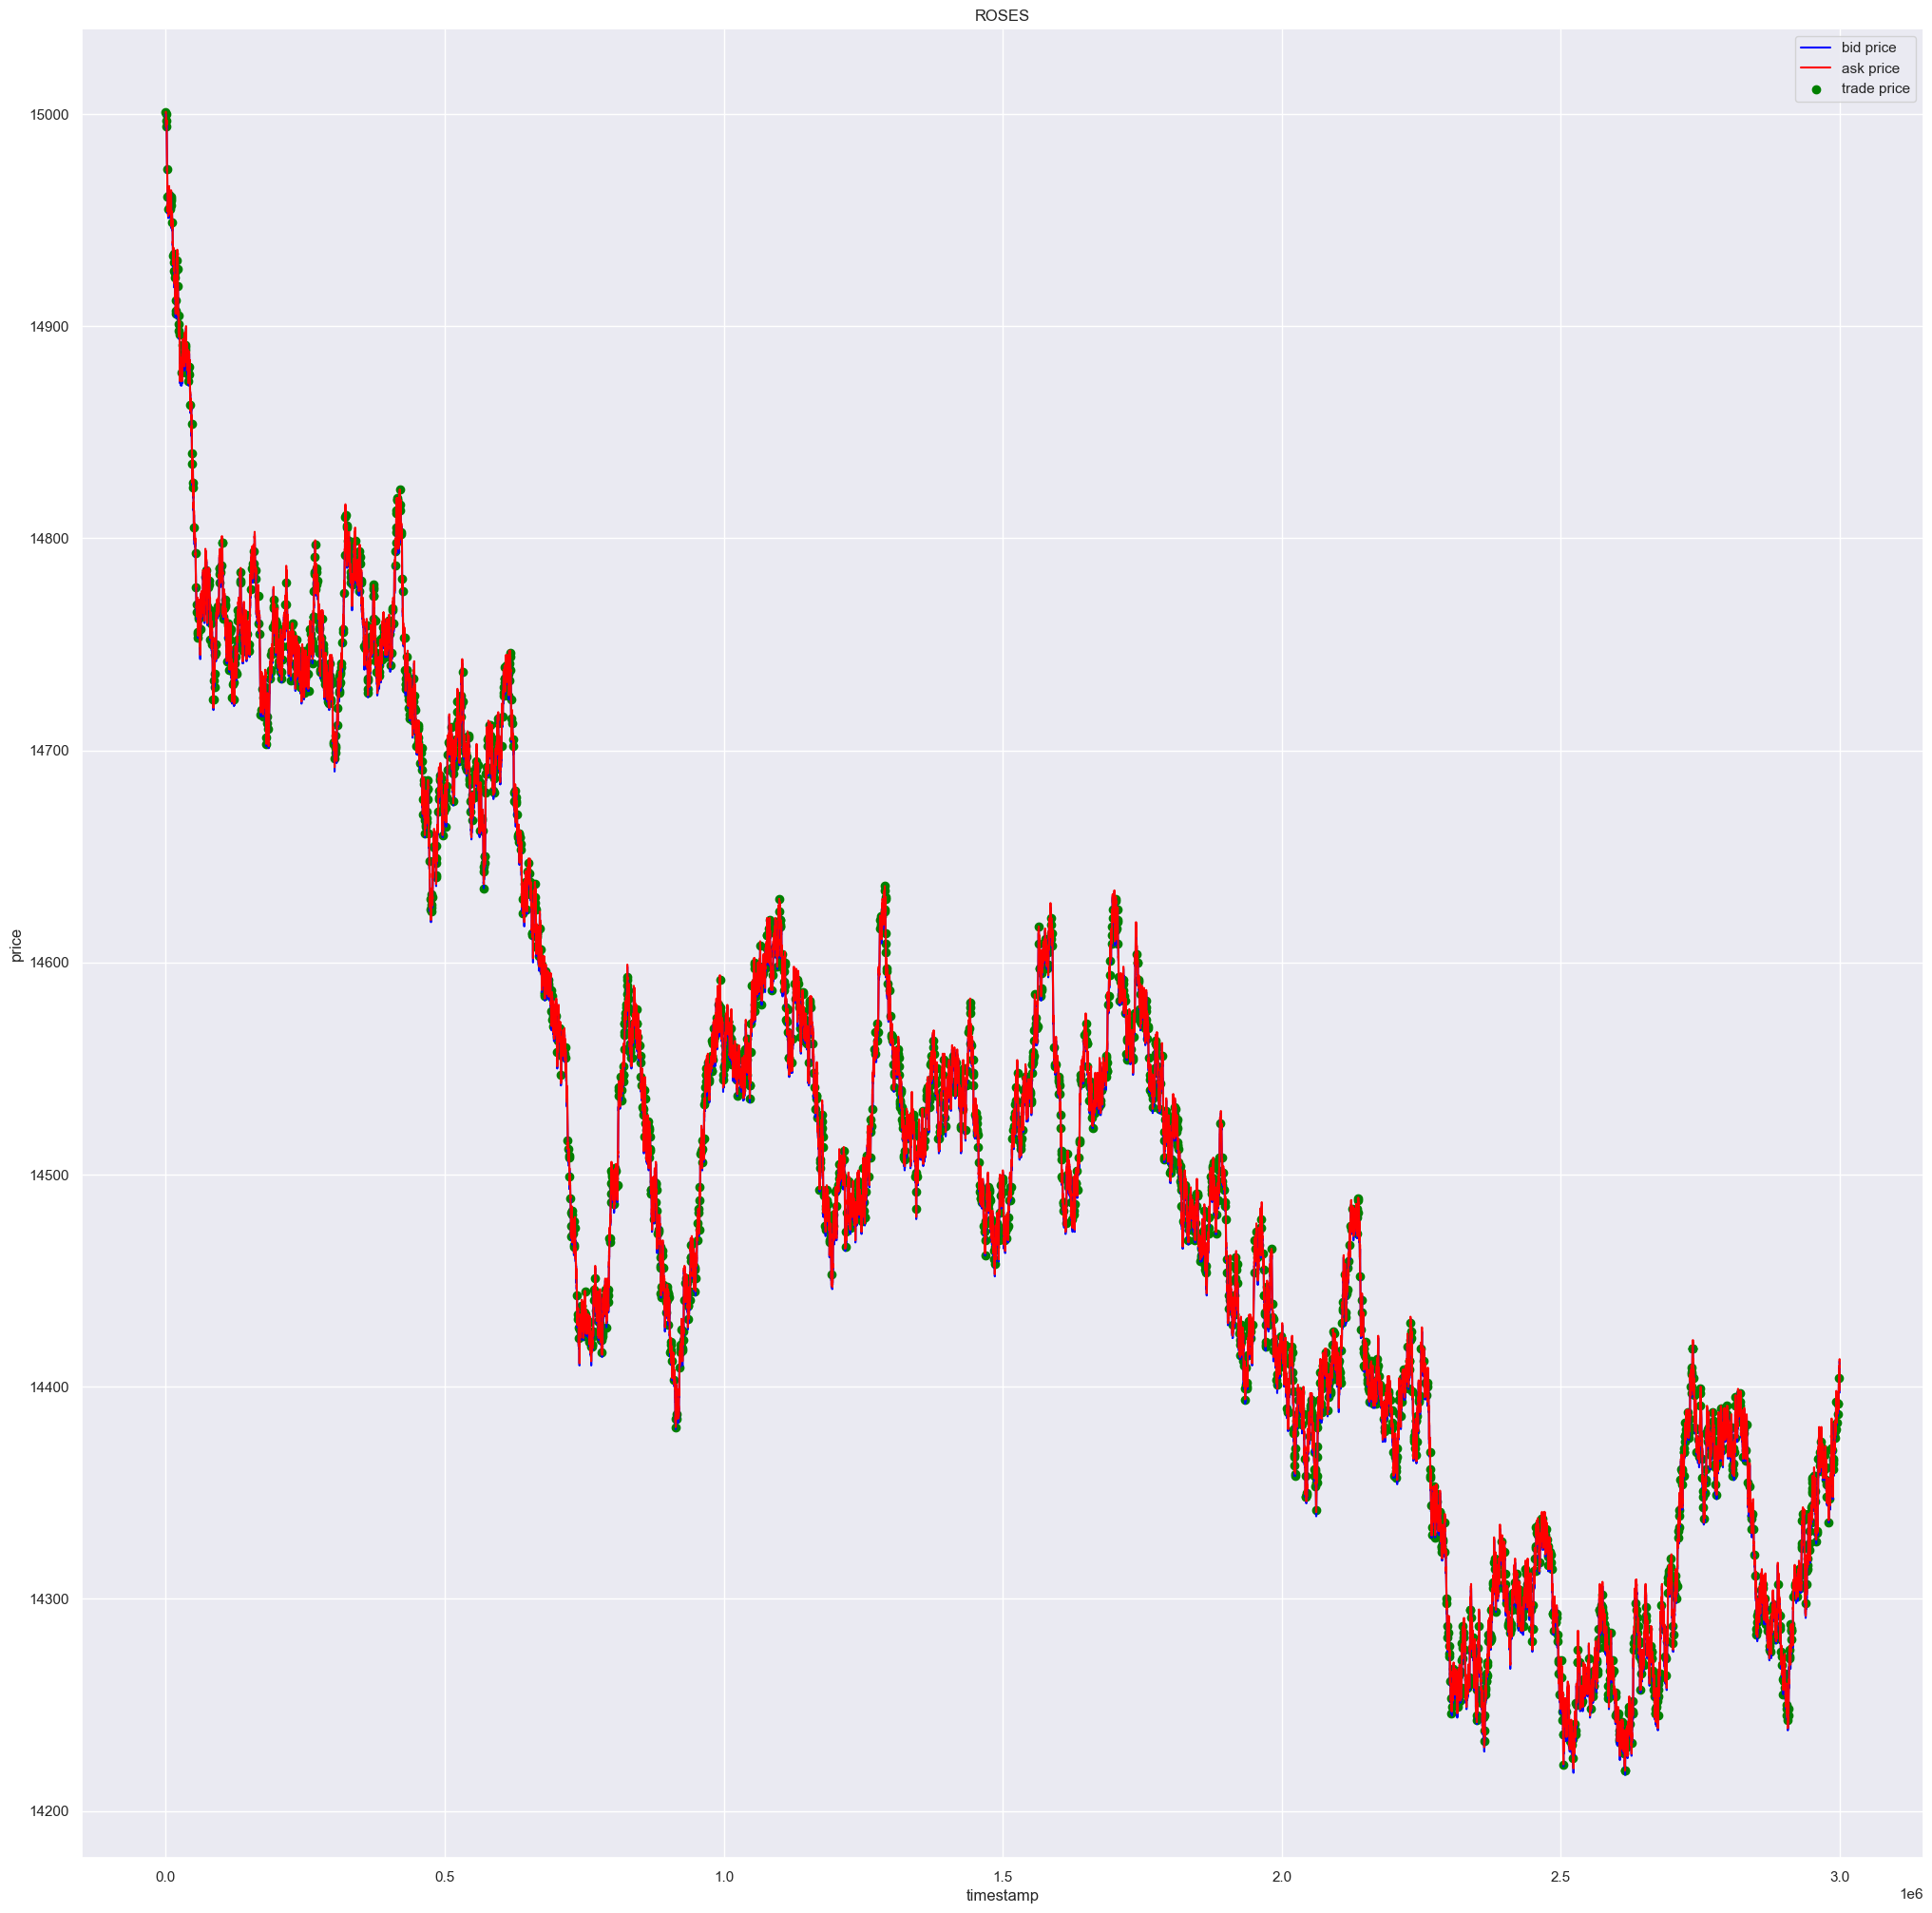

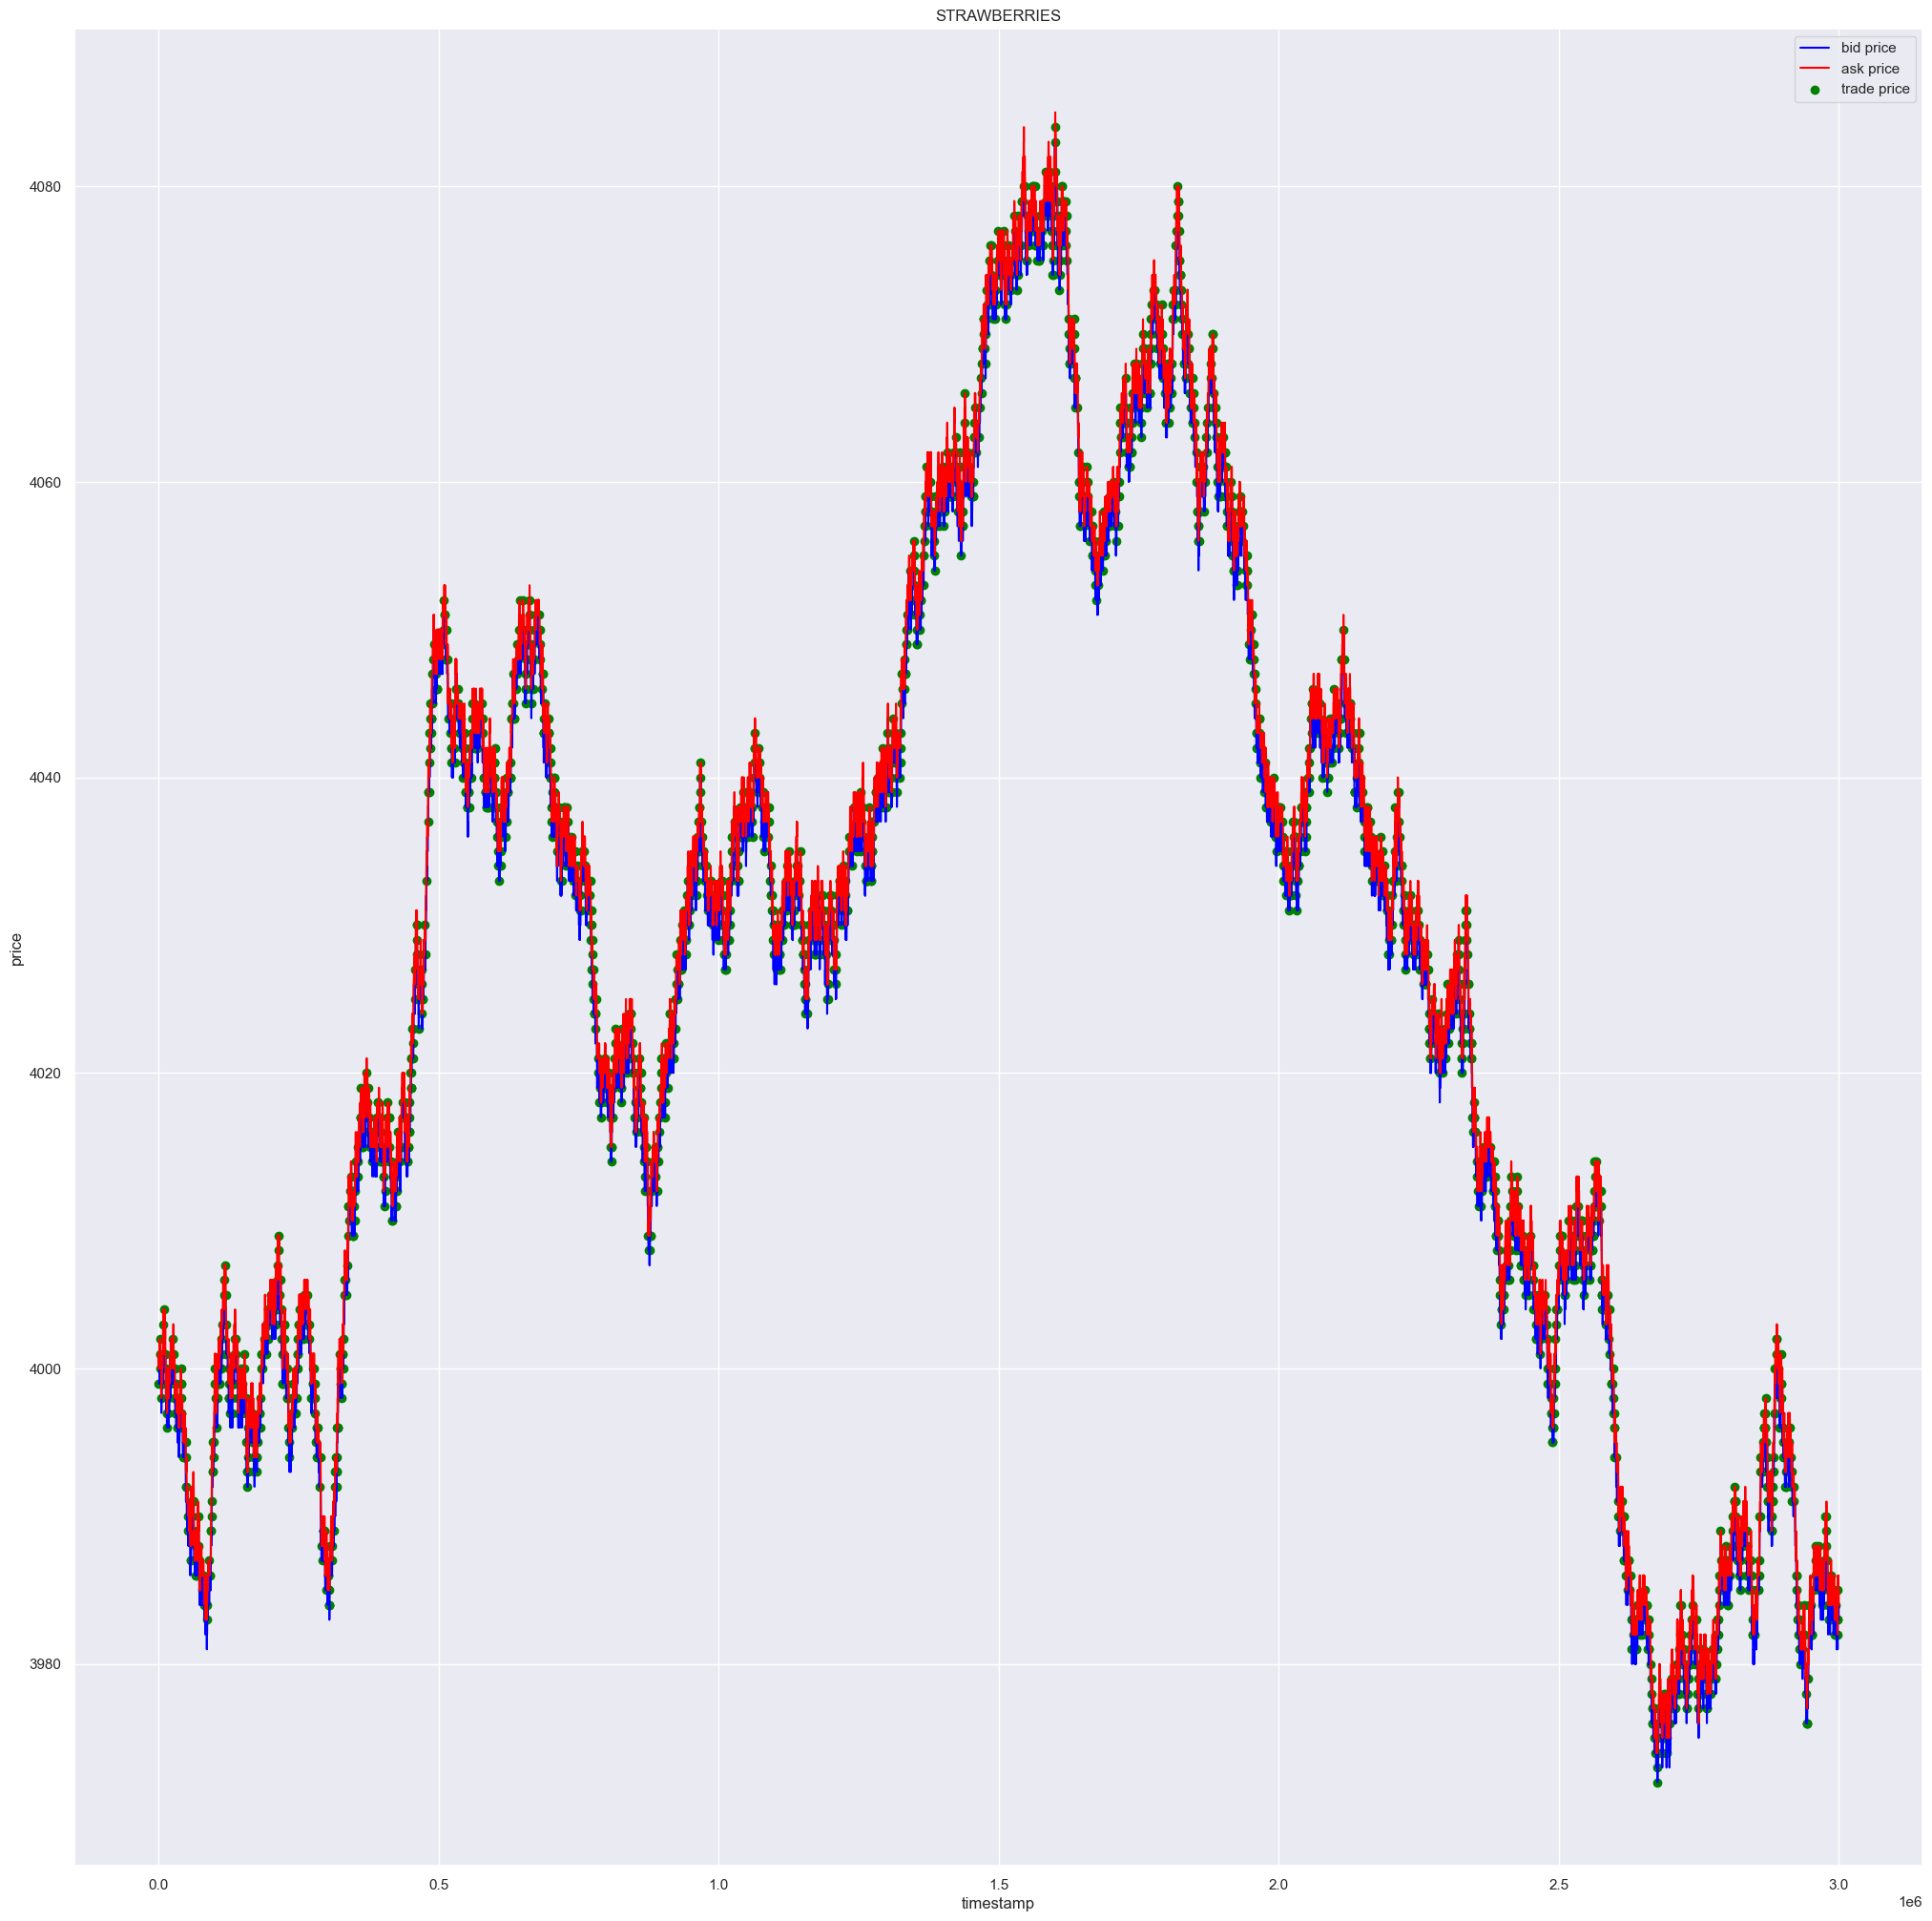

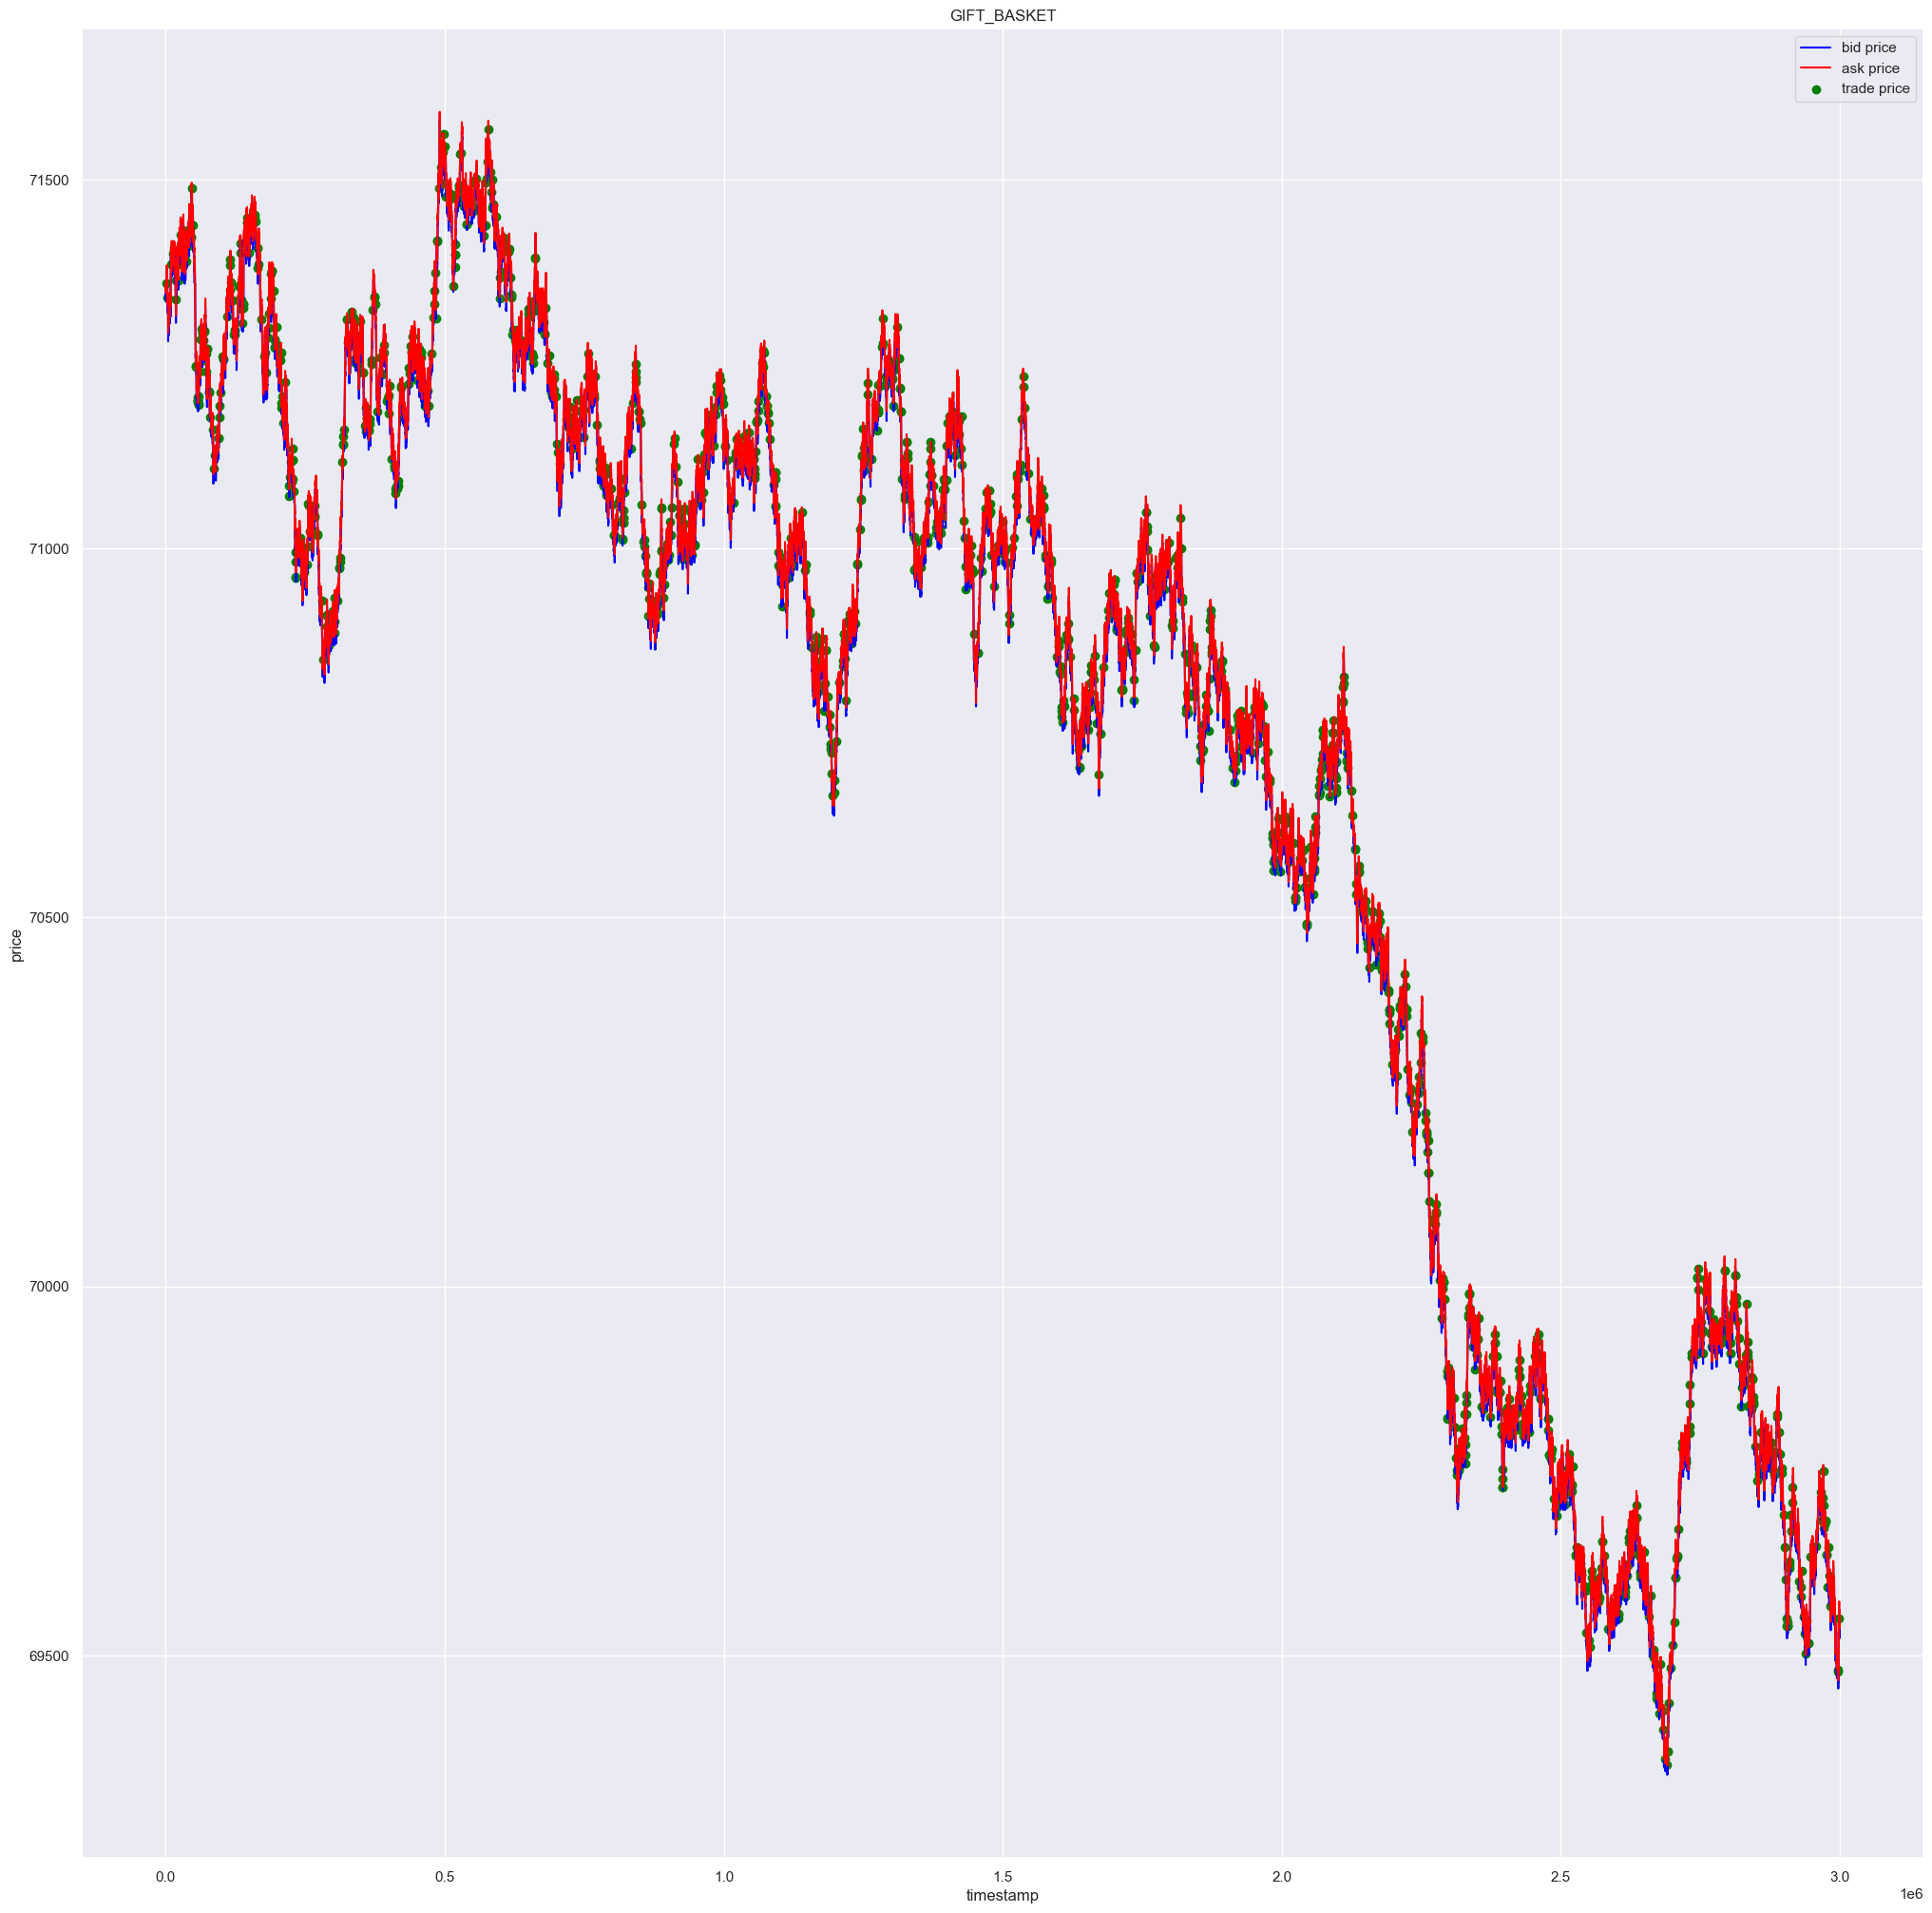

In [82]:
# plot all the bids, asks per product: CHOCOLATE, ROSES, STRAWBERRIES, and GIFT_BASKET

products = ["CHOCOLATE", "ROSES", "STRAWBERRIES", "GIFT_BASKET"]

for product in products:
    product_prices = prices[prices["product"] == product]
    product_trades = trades[trades["symbol"] == product]

    fig, ax = plt.subplots(figsize=(25,25))
    ax.plot(product_prices["timestamp"], product_prices["bid_price_1"], label="bid price", color="blue")
    ax.plot(product_prices["timestamp"], product_prices["ask_price_1"], label="ask price", color="red")
    ax.scatter(product_trades["timestamp"], product_trades["price"], label="trade price", color="green")
    ax.set_title(product)
    ax.set_xlabel("timestamp")
    ax.set_ylabel("price")
    ax.legend()
    plt.show()

/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_78933/3775005905.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basket_prices["underlying_value"] = 4 * chocolate_prices["mid_price"] + rose_prices["mid_price"] + 6 * strawberry_prices["mid_price"]


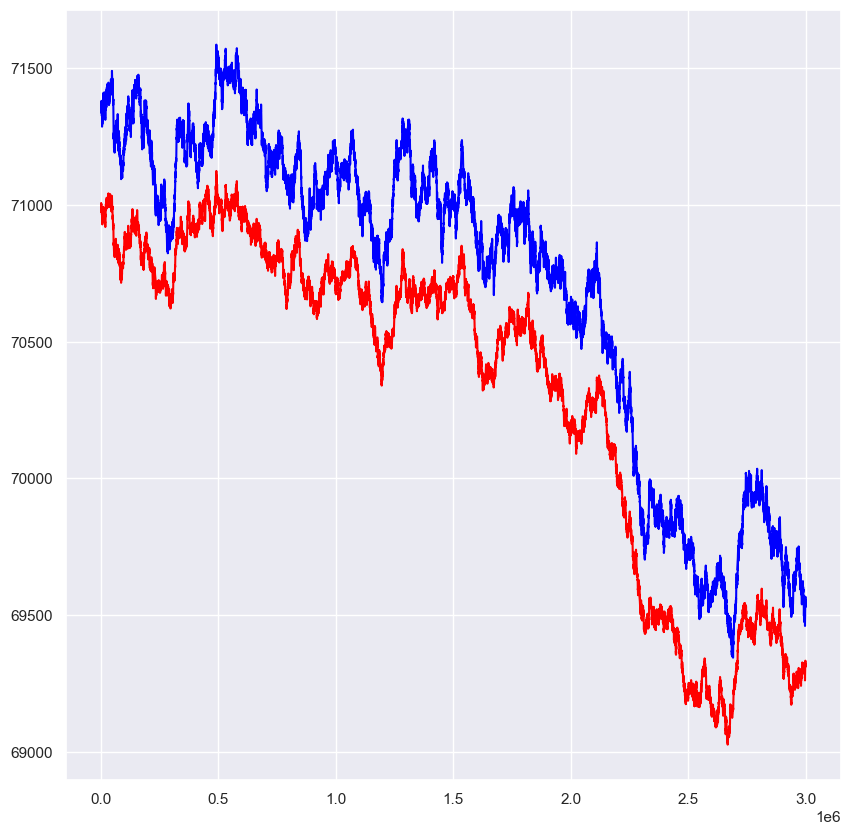

In [83]:
# Plot the price of the basket vs the value of the underlying products: 4 chocolates, 1 rose, 3 strawberries

# set index to timestamp
prices.set_index("timestamp", inplace=True)

chocolate_prices = prices[prices["product"] == "CHOCOLATE"]
# calculate ema for chocolate prices

rose_prices = prices[prices["product"] == "ROSES"]

strawberry_prices = prices[prices["product"] == "STRAWBERRIES"]

basket_prices = prices[prices["product"] == "GIFT_BASKET"]

basket_prices["underlying_value"] = 4 * chocolate_prices["mid_price"] + rose_prices["mid_price"] + 6 * strawberry_prices["mid_price"]

# basket_prices["value_ratio"] = basket_prices["mid_price"] / basket_prices["underlying_value"]

# reset index
prices.reset_index(inplace=True)

basket_prices.reset_index(inplace=True)
# plot the underlying value of the basket vs the price of the basket over timestamp

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(basket_prices["timestamp"], basket_prices["mid_price"], label="basket price", color="blue")
ax.plot(basket_prices["timestamp"], basket_prices["underlying_value"], label="underlying value", color="red")


/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_78933/4257032290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basket_prices["value_ratio"] = basket_prices["mid_price"] - basket_prices["underlying_value"]


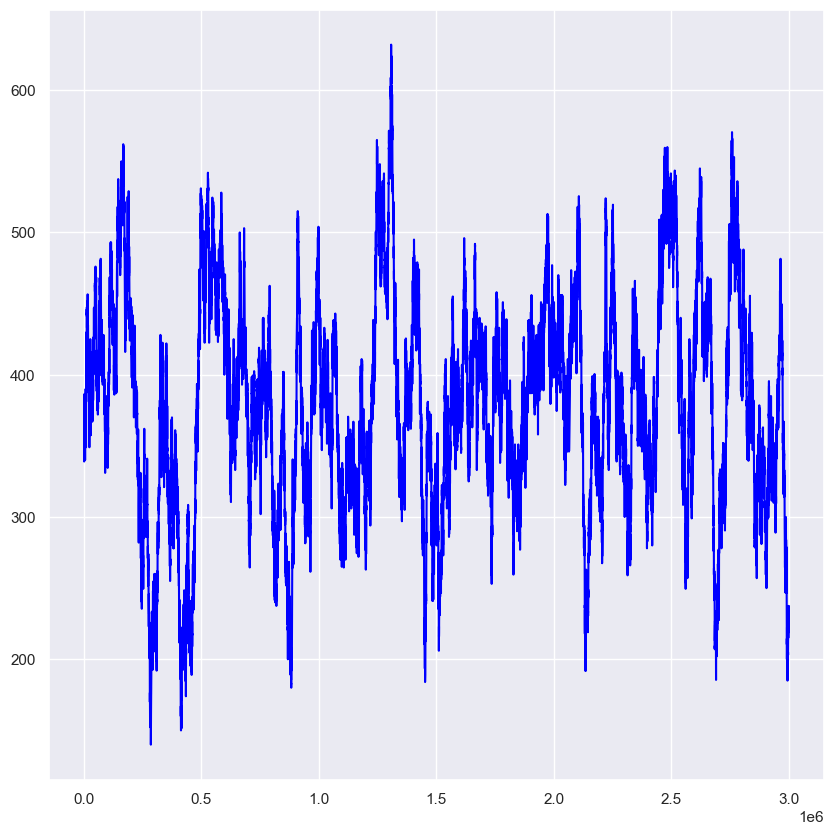

In [84]:
basket_prices["value_ratio"] = basket_prices["mid_price"] - basket_prices["underlying_value"]

# plot the ratio of the basket price to the underlying value
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(basket_prices["timestamp"], basket_prices["value_ratio"], label="basket price / underlying value", color="blue")

# get the mean of the 


# Linear Regression

In [85]:

trades_d0 = pd.read_csv('data/trades_round_3_day_0_nn.csv', delimiter=';')
trades_d1 = pd.read_csv('data/trades_round_3_day_1_nn.csv', delimiter=';')
trades_d1["timestamp"] += trades_d0["timestamp"].iloc[-1] + 100
trades_d2 = pd.read_csv('data/trades_round_3_day_2_nn.csv', delimiter=';')
trades_d2["timestamp"] += trades_d1["timestamp"].iloc[-1] + 100

trades = pd.concat([trades_d0, trades_d1, trades_d2])



prices_d0 = pd.read_csv('data/prices_round_3_day_0.csv', delimiter=';')
prices_d1 = pd.read_csv('data/prices_round_3_day_1.csv', delimiter=';')
prices_d1["timestamp"] += prices_d0["timestamp"].iloc[-1] + 100
prices_d2 = pd.read_csv('data/prices_round_3_day_2.csv', delimiter=';')
prices_d2["timestamp"] += prices_d1["timestamp"].iloc[-1] + 100

prices = pd.concat([prices_d0, prices_d1, prices_d2])


chocolate_data = trades[trades["symbol"] == "CHOCOLATE"]

In [86]:


trades['total'] = trades['price'] * trades['quantity']
trades.rename(columns={'symbol':'product'}, inplace = True)
trade_summary = trades.groupby(['timestamp','product']).agg({'quantity':'sum', 'total':'sum'})
trade_summary = trade_summary.groupby(['product'])[['quantity','total']].cumsum()
trade_summary['vwap'] = trade_summary['total']/ trade_summary['quantity']
trade_summary.groupby(['product'])[['quantity','total']].cumsum()

trade_summary.reset_index(inplace = True)


In [87]:
# print headers of trade_summary


In [88]:

data = pd.merge(prices, trade_summary, on = ['timestamp','product'], how="left")

data[['quantity','total', 'vwap']] = data.groupby('product')[['quantity','total','vwap']].fillna(method='ffill')
data['vwap'] = data.groupby('product')['vwap'].fillna(data['mid_price'])
data[['quantity','total','vwap']] = data.groupby('product')[['quantity','total','vwap']].shift()
data.set_index('timestamp', inplace = True)
data[['bid_volume_1','bid_volume_2','bid_volume_3','ask_volume_1','ask_volume_2','ask_volume_3']] = data[['bid_volume_1','bid_volume_2','bid_volume_3','ask_volume_1','ask_volume_2','ask_volume_3']].fillna(0)

/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_78933/148032367.py:3: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  data[['quantity','total', 'vwap']] = data.groupby('product')[['quantity','total','vwap']].fillna(method='ffill')
/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_78933/148032367.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[['quantity','total', 'vwap']] = data.groupby('product')[['quantity','total','vwap']].fillna(method='ffill')
/var/folders/r2/pw988w7d4qj5t2yych02l3m80000gp/T/ipykernel_78933/148032367.py:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling i

In [89]:
data['total_bid_volume'] = data[['bid_volume_1','bid_volume_2','bid_volume_3']].sum(axis = 1)
data['total_ask_volume'] = data[['ask_volume_1','ask_volume_2','ask_volume_3']].sum(axis = 1)

In [90]:
data['imbalance'] = (data['total_bid_volume'] - data['total_ask_volume']) / (data['total_bid_volume'] + data['total_ask_volume'])
data['spread'] = data['ask_price_1'] - data['bid_price_1'] 

In [91]:
product = ["CHOCOLATE", "ROSES", "STRAWBERRIES", "GIFT_BASKET"]
# product = "CHOCOLATE"

In [92]:
def get_train(product):
    data_train = data[data["product"] == product]
    data_train = data_train[['mid_price','imbalance','spread','vwap']]
    data_train['mid_price_1'] = data_train['mid_price'].shift(1)
    data_train['mid_price_2'] = data_train['mid_price'].shift(2)
    data_train['mid_price_3'] = data_train['mid_price'].shift(3)
    data_train['imbalance_1'] = data_train['imbalance'].shift(1)
    data_train['spread_1'] = data_train['spread'].shift(1)
    data_train['vwap_1'] = data_train['vwap'].shift(1)
    data_train = data_train[['mid_price_3','mid_price_2','mid_price_1','mid_price','imbalance_1','imbalance','spread_1','spread','vwap_1','vwap']]
    return data_train

In [93]:
data_train = get_train('CHOCOLATE')
X_train = data_train[3:20000]
y_train = data_train['mid_price'].shift(-1)[3:20000]
X_test, y_test = data_train[20000:-1], data_train['mid_price'].shift(-1)[20000:-1]

In [94]:
def objective(trial, X_train, y_train, X_val, y_val) -> float:
    '''
    The oobjective function for the optimisation problem.
    
    Args:
        trial: optuna.trial object
        X_train: ndarray or DataFrame, The features of training dataset
        y_train: Index or array-like, The Target of training dataset
        X_val: ndarray or DataFrame, The features of validation dastaset
        y_val: Index or array-like, The Target of validation dataset

    Returns:
        numeric, the performance mertic for the model training
    '''
    # the parameters you want to optimise and the sapce you wanna search
    param_grid = {
        'alpha': trial.suggest_float('alpha', 1e-15, 10.0, log = True),
    }
    model =  Ridge(**param_grid,
                #    fit_intercept= False
                   )
    
    model.fit(
        X_train,
        y_train
    )
    
    coef = model.coef_
    intercept = model.intercept_
    
    y_pred = model.predict(X_val)
    
    # profit = hypertune.get_profit(round_1_train.Trader(intercept = intercept, coef = coef))
    mse = mean_squared_error(y_val, y_pred)
    return mse

def hyper_tune(X_train, y_train, direction="minimize", n_trials=30, test_size=0.3):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
    study_name="Linear Regression"
    direction=direction # maximize or minimize
    n_trials=n_trials

    study = optuna.create_study(direction=direction, study_name=study_name)
    func = lambda trial: objective(trial, X_train, y_train, X_val, y_val)
    study.optimize(func, n_trials=n_trials)
    return study

In [95]:
study = hyper_tune(X_train, y_train)

[I 2024-04-16 22:45:22,715] A new study created in memory with name: Linear Regression
[I 2024-04-16 22:45:22,721] Trial 0 finished with value: 1.0733738418727687 and parameters: {'alpha': 0.0017915725939767573}. Best is trial 0 with value: 1.0733738418727687.
[I 2024-04-16 22:45:22,732] Trial 1 finished with value: 1.0733743312140291 and parameters: {'alpha': 4.4777180516672e-05}. Best is trial 0 with value: 1.0733738418727687.
[I 2024-04-16 22:45:22,743] Trial 2 finished with value: 1.073364692149416 and parameters: {'alpha': 0.046672961781706615}. Best is trial 2 with value: 1.073364692149416.
[I 2024-04-16 22:45:22,754] Trial 3 finished with value: 1.0736291583516946 and parameters: {'alpha': 4.9277087423719825}. Best is trial 2 with value: 1.073364692149416.
[I 2024-04-16 22:45:22,773] Trial 4 finished with value: 1.0733743439071204 and parameters: {'alpha': 1.3788719507452305e-14}. Best is trial 2 with value: 1.073364692149416.
[I 2024-04-16 22:45:22,808] Trial 5 finished with va

In [96]:
model =  Ridge(**study.best_params
               , fit_intercept= False
               )

model.fit(
    X_train,
    y_train
)

Ridge(alpha=0.10945471186986203, fit_intercept=False)

In [97]:
y_pred = model.predict(X_test)

# profit = hypertune.get_profit(round_1_train.Trader(intercept = intercept, coef = coef))
mse = mean_squared_error(y_test, y_pred)

In [98]:
model.score(X_test, y_test)

0.9996609934483053

In [99]:
model.coef_

array([-0.00438708,  0.0030895 ,  0.01754449,  0.98358815, -0.86849243,
       -2.69168902,  0.0271194 , -0.00315138,  0.11325747, -0.11309815])

In [100]:
# all models have no intercept, i.e.  intecept = 0
CHOCOLATE = [-0.00437733,  0.00308218,  0.01752576,  0.98360442, -0.90183322,
       -2.79369535,  0.02711808, -0.00315843,  0.11274011, -0.11258077]
ROSES = [-0.00981411,  0.00393729,  0.01444269,  0.99055514, -0.0615577 ,
       -0.3335764 ,  0.03956394, -0.04242976, -0.07749774,  0.07836905]
STRAWBERRIES = [-0.01862957,  0.0360459 ,  0.11510304,  0.86723537, -0.04803083,
       -1.15100102, -0.00741988, -0.02239479, -0.00789983,  0.0081571 ]
GIFT_BASKET = [-4.93091977e-03,  2.60248787e-03,  8.98806498e-03,  9.92372840e-01,
       -8.29595831e-02,  8.40848233e+00, -3.31841259e-02,  2.30186523e-02,
       -1.88540730e-01,  1.89507642e-01]


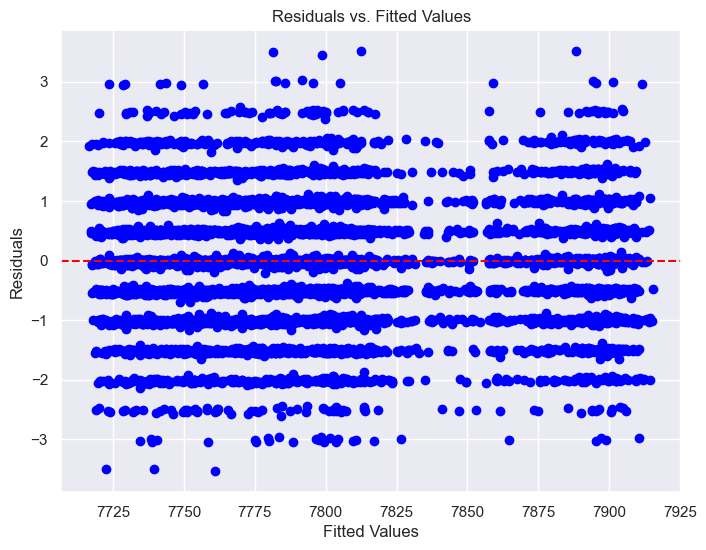

In [101]:
import statsmodels.api as sm

# Residual plot
residuals = y_test - y_pred

# Create the Residuals vs. Fitted Values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [102]:
# calculate predicted values for each product 

# CHOCOLATE = [-0.00437733,  0.00308218,  0.01752576,  0.98360442, -0.90183322,
#           -2.79369535,  0.02711808, -0.00315843,  0.11274011, -0.11258077]
# ROSES = [-0.00981411,  0.00393729,  0.01444269,  0.99055514, -0.0615577 ,
#        -0.3335764 ,  0.03956394, -0.04242976, -0.07749774,  0.07836905]
# STRAWBERRIES = [-0.01862957,  0.0360459 ,  0.11510304,  0.86723537, -0.04803083,
#        -1.15100102, -0.00741988, -0.02239479, -0.00789983,  0.0081571 ]

# def get_train(product):
#     data_train = data[data["product"] == product]
#     data_train = data_train[['mid_price','imbalance','spread','vwap']]
#     data_train['mid_price_1'] = data_train['mid_price'].shift(1)
#     data_train['mid_price_2'] = data_train['mid_price'].shift(2)
#     data_train['mid_price_3'] = data_train['mid_price'].shift(3)
#     data_train['imbalance_1'] = data_train['imbalance'].shift(1)
#     data_train['spread_1'] = data_train['spread'].shift(1)
#     data_train['vwap_1'] = data_train['vwap'].shift(1)
#     data_train = data_train[['mid_price_3','mid_price_2','mid_price_1','mid_price','imbalance_1','imbalance','spread_1','spread','vwap_1','vwap']]
#     return data_train



    

basket_data = get_train("GIFT_BASKET")
    
intercept = 0

chocolate_coeff = [-0.00437733,  0.00308218,  0.01752576,  0.98360442, -0.90183322, -2.79369535,  0.02711808, -0.00315843,  0.11274011, -0.11258077]

chocolate_data = get_train("CHOCOLATE")

basket_data["chocolate_predicted_price"] = chocolate_data["mid_price_3"] * chocolate_coeff[0] + chocolate_data["mid_price_2"] * chocolate_coeff[1] + chocolate_data["mid_price_1"] * chocolate_coeff[2] + chocolate_data["mid_price"] * chocolate_coeff[3] + chocolate_data["imbalance_1"] * chocolate_coeff[4] + chocolate_data["imbalance"] * chocolate_coeff[5] + chocolate_data["spread_1"] * chocolate_coeff[6] + chocolate_data["spread"] * chocolate_coeff[7] + chocolate_data["vwap_1"] * chocolate_coeff[8] + chocolate_data["vwap"] * chocolate_coeff[9] + intercept

strawberry_coeff = [-0.01862957,  0.0360459 ,  0.11510304,  0.86723537, -0.04803083, -1.15100102, -0.00741988, -0.02239479, -0.00789983,  0.0081571 ]

strawberry_data = get_train("STRAWBERRIES")

basket_data["strawberry_predicted_price"] = strawberry_data["mid_price_3"] * strawberry_coeff[0] + strawberry_data["mid_price_2"] * strawberry_coeff[1] + strawberry_data["mid_price_1"] * strawberry_coeff[2] + strawberry_data["mid_price"] * strawberry_coeff[3] + strawberry_data["imbalance_1"] * strawberry_coeff[4] + strawberry_data["imbalance"] * strawberry_coeff[5] + strawberry_data["spread_1"] * strawberry_coeff[6] + strawberry_data["spread"] * strawberry_coeff[7] + strawberry_data["vwap_1"] * strawberry_coeff[8] + strawberry_data["vwap"] * strawberry_coeff[9] + intercept


roses_coeff = [-0.00981411,  0.00393729,  0.01444269,  0.99055514, -0.0615577, -0.3335764 ,  0.03956394, -0.04242976, -0.07749774,  0.07836905]

roses_data = get_train("ROSES")

basket_data["roses_predicted_price"] = roses_data["mid_price_3"] * roses_coeff[0] + roses_data["mid_price_2"] * roses_coeff[1] + roses_data["mid_price_1"] * roses_coeff[2] + roses_data["mid_price"] * roses_coeff[3] + roses_data["imbalance_1"] * roses_coeff[4] + roses_data["imbalance"] * roses_coeff[5] + roses_data["spread_1"] * roses_coeff[6] + roses_data["spread"] * roses_coeff[7] + roses_data["vwap_1"] * roses_coeff[8] + roses_data["vwap"] * roses_coeff[9] + intercept


basket_data = basket_data[['mid_price','imbalance','spread','chocolate_predicted_price','strawberry_predicted_price','roses_predicted_price']]

In [103]:
X_train = basket_data[3:20000]
y_train = basket_data['mid_price'].shift(-1)[3:20000]
X_test, y_test = basket_data[20000:-1], basket_data['mid_price'].shift(-1)[20000:-1]

In [104]:
study = hyper_tune(X_train, y_train)

[I 2024-04-16 22:45:23,535] A new study created in memory with name: Linear Regression
[I 2024-04-16 22:45:23,552] Trial 0 finished with value: 65.17062298885303 and parameters: {'alpha': 2.123601139484421e-14}. Best is trial 0 with value: 65.17062298885303.
[I 2024-04-16 22:45:23,564] Trial 1 finished with value: 65.17060571856975 and parameters: {'alpha': 0.12923765793176048}. Best is trial 1 with value: 65.17060571856975.
[I 2024-04-16 22:45:23,568] Trial 2 finished with value: 65.17062298884949 and parameters: {'alpha': 2.4029352626312846e-08}. Best is trial 1 with value: 65.17060571856975.
[I 2024-04-16 22:45:23,576] Trial 3 finished with value: 65.17062298884615 and parameters: {'alpha': 2.3950575452465602e-08}. Best is trial 1 with value: 65.17060571856975.
[I 2024-04-16 22:45:23,586] Trial 4 finished with value: 65.1706228375195 and parameters: {'alpha': 0.0010744668912474507}. Best is trial 1 with value: 65.17060571856975.
[I 2024-04-16 22:45:23,592] Trial 5 finished with valu

In [105]:
model =  Ridge(**study.best_params
               , fit_intercept= False
               )

model.fit(
    X_train,
    y_train
)


y_pred = model.predict(X_test)

# profit = hypertune.get_profit(round_1_train.Trader(intercept = intercept, coef = coef))
mse = mean_squared_error(y_test, y_pred)


model.score(X_test, y_test)

0.9995398019414681

In [106]:
model.coef_


array([9.96390319e-01, 8.48919748e+00, 2.23259588e-02, 1.46613902e-02,
       2.19682410e-02, 3.47660363e-03])

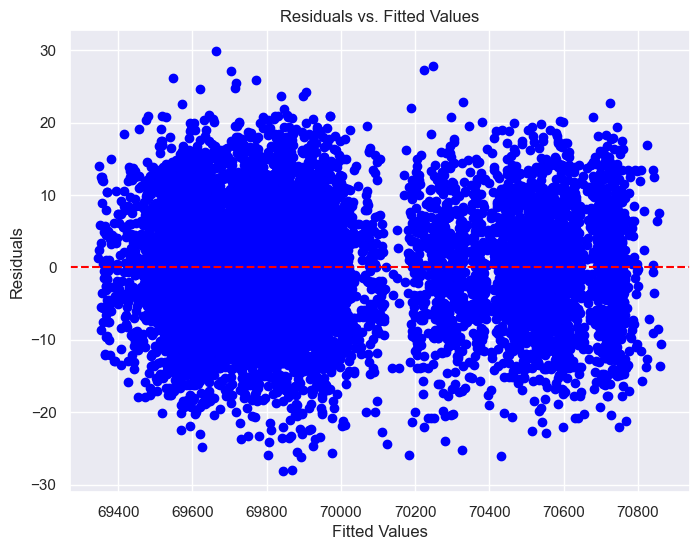

In [107]:
import statsmodels.api as sm

# Residual plot
residuals = y_test - y_pred

# Create the Residuals vs. Fitted Values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [ ]:
GIFT_BASKET = [9.96390319e-01, 8.48919748e+00, 2.23259588e-02, 1.46613902e-02, 2.19682410e-02, 3.47660363e-03]

# BASKET STRATEGY

In [7]:
diff = prices.query('product == "GIFT_BASKET"').mid_price.reset_index(drop=True) - prices.query('product == "CHOCOLATE"').mid_price.reset_index(drop=True) * 4 - prices.query('product == "STRAWBERRIES"').mid_price.reset_index(drop=True) * 6 - prices.query('product == "ROSES"').mid_price.reset_index(drop=True)

In [10]:
prices.query('product == "CHOCOLATES"').mid_price.reset_index(drop=True)

Series([], Name: mid_price, dtype: float64)

In [11]:
prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2,2999800,GIFT_BASKET,69537,2,69536.0,18.0,69535.0,24.0,69547,2,69548.0,18.0,69550.0,24.0,69542.0,0.0
39996,2,2999900,CHOCOLATE,7749,143,NaN,NaN,NaN,NaN,7751,143,NaN,NaN,NaN,NaN,7750.0,0.0
39997,2,2999900,GIFT_BASKET,69551,1,69550.0,19.0,69549.0,20.0,69561,1,69562.0,19.0,69564.0,20.0,69556.0,0.0
39998,2,2999900,STRAWBERRIES,3984,240,NaN,NaN,NaN,NaN,3985,92,3986.0,148.0,NaN,NaN,3984.5,0.0
